In [57]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [67]:
# standard parameters:
# sigma = 10.
# rho = 28.
# beta = 8 / 3
rho = 10
sigma = 15
beta = 8 / 3

# scaled1 shifts:
# shift_x = - 0.013895
# shift_y = - 0.013791
# shift_z = 23.584181

shift_x = 0
shift_y = 0
shift_z = 9.

# std: 8.533635
# scaled1: 26.8356
scaling = 10 #26.8356

In [68]:
def normalized_dynamic(t, r, shift_x, shift_y, shift_z, scaling):
    """
    Rhs of the normalized Lorenz system
    """
    x, y, z = r
    
    fx = sigma * ((y + shift_y / scaling) - (x + shift_x / scaling))
    fy = scaling * (x + shift_x / scaling) * (rho / scaling - (z + shift_z / scaling)) - (y + shift_y / scaling)
    fz = scaling * (x + shift_x / scaling) * (y + shift_y / scaling) - beta * (z + shift_z / scaling)
    
    return np.array([fx, fy, fz])

In [69]:
def get_solution(max_t, delta_t, init_val):
    
    times = np.linspace(0, max_t, int(max_t / delta_t) + 1)
    sol = solve_ivp(
        normalized_dynamic, [0, max_t], init_val, t_eval=times,
        args=(shift_x, shift_y, shift_z, scaling)
    )
    
    return sol.y.T


def plot_3d_points(points):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
    
    return fig, ax


def plot_3d_curve(sol, ax=None, **kwargs):

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection="3d")

    ax.plot(sol[:, 0], sol[:, 1], sol[:, 2], lw=1, **kwargs)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    return ax

In [70]:
def solutions_second_half(init_vals, max_t, delta_t=0.1):
    
    n_solutions = len(init_vals)
    len_per_sol = len(get_solution(max_t, delta_t, init_vals[0])) // 2
    
    points = np.empty((n_solutions * len_per_sol, 3), dtype=float)
    
    for i, init_val in enumerate(init_vals):
        
        sol = get_solution(max_t, delta_t, init_val)
        points[i * len_per_sol : (i+1) * len_per_sol, :] = sol[-(len(sol) // 2), :]
    
    return points

In [71]:
# random initial values in [-40, 40] x [-40, 40] x [-25, 25]
n_inits = 100

init_x = np.random.uniform(-40, 40, n_inits)
init_y = np.random.uniform(-40, 40, n_inits)
init_z = np.random.uniform(-25, 25, n_inits)

init_vals = np.vstack([init_x, init_y, init_z]).T

scaled = True

if scaled:
    init_vals *= scaling

max_t = 50

In [72]:
points = solutions_second_half(init_vals, max_t)

print(points.shape)

(25000, 3)


In [73]:
print(max(points[:,0]), max(points[:,1]), max(points[:,2]))
print(min(points[:,0]), min(points[:,1]), min(points[:,2]))

print(f"mean x: {np.mean(points[:,0])}")
print(f"mean y: {np.mean(points[:,1])}")
print(f"mean z: {np.mean(points[:,2])}")

print(f"std: {np.std(points)}")

0.4899038416150724 0.48989856303826224 1.4283388134782075e-06
-0.4899044855605436 -0.48989870196353325 -1.77841620885864e-06
mean x: -0.019595832689613107
mean y: -0.019595921227096746
mean z: -3.215446290093003e-07
std: 0.39978696365196664


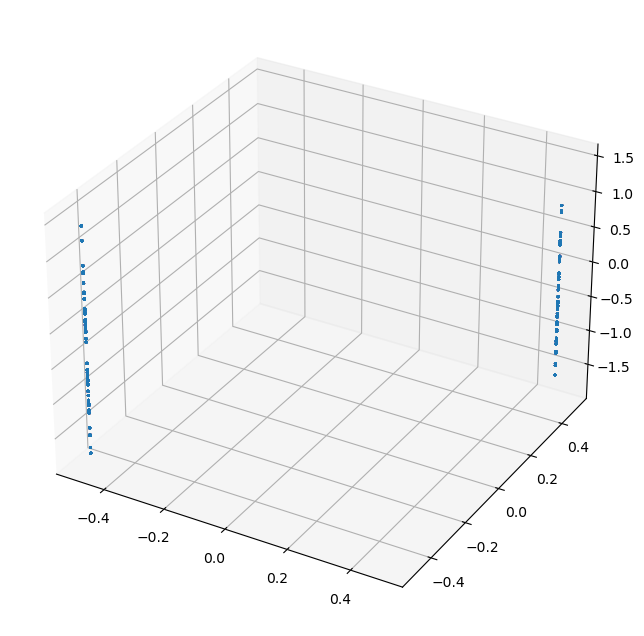

In [74]:
n_points_plot = 10000

np.random.shuffle(points)
fig, ax = plot_3d_points(points[: n_points_plot,:])
plt.show()

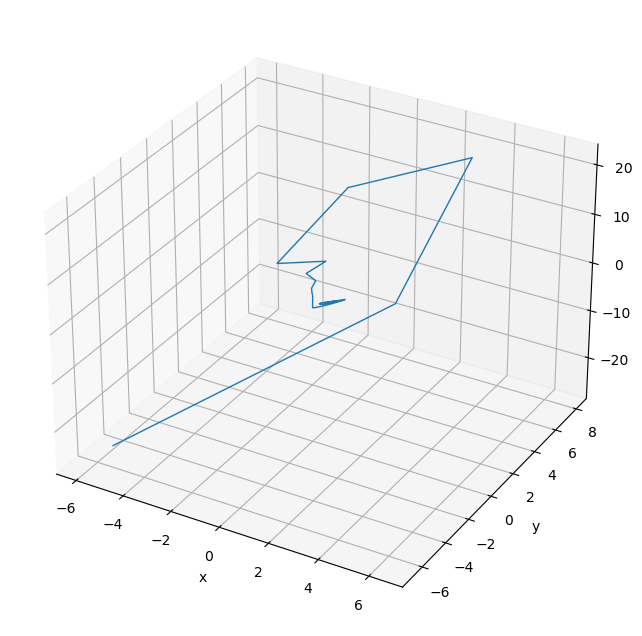

In [75]:
init_val = np.random.uniform(-40, 40, 3)
true_solution = get_solution(max_t=100, delta_t=0.1, init_val=init_val)

ax = plot_3d_curve(true_solution)
plt.show()

In [10]:
# get noisy initial values
init_value_cloud = np.empty((3 * len(points), 3), dtype=float)

var = .025
cov = np.diag(np.full(3, var))

for i, point in enumerate(points):
    init_value_cloud[3 * i : 3 * (i + 1), :] = np.random.multivariate_normal(point, cov, size=3)

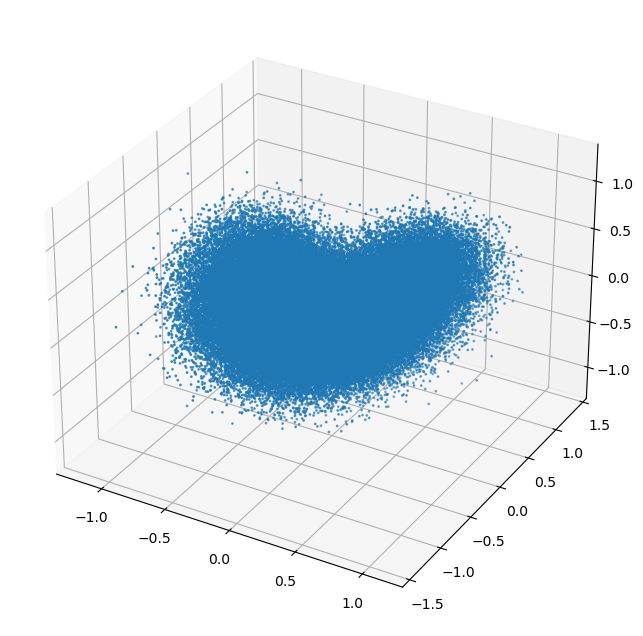

In [11]:
np.random.shuffle(init_value_cloud)
fig, ax = plot_3d_points(init_value_cloud[: n_points_plot,:])
plt.show()

In [12]:
# save initial values for tcPINN training
for n_points in [1e4, 5e4, 1e5, 2e5, 3e5, 5e5]:
    
    np.random.shuffle(init_value_cloud)
    np.save(f"init_values_{int(n_points)}_scaled1.npy", init_value_cloud[:int(n_points), :])